In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [19]:
# read data
df_monthly_2012_2021_wt_ws = pd.read_csv('Use this dataset/monthly_data_2012_2021_wt_ws.csv', na_values='.')

In [20]:
# date to datetime and set date as index
df_monthly_2012_2021_wt_ws['date'] = pd.to_datetime(df_monthly_2012_2021_wt_ws['date'])
df_monthly_2012_2021_wt_ws = df_monthly_2012_2021_wt_ws.sort_values(by='date')
df_monthly_2012_2021_wt_ws = df_monthly_2012_2021_wt_ws.set_index('date')

In [21]:
# drop all column and na
df_monthly_2012_2021_wt_ws_netgen = df_monthly_2012_2021_wt_ws.drop(['YEAR', 'Month', 'Reported\nPrime Mover', 'Plant Id', 'Operator Name',
                                                              'Quantity', 'Elec_Quantity', 'MMBtuPer_Unit', 'Tot_MMBtu', 'Elec_MMBtu'], axis=1)
print(len(df_monthly_2012_2021_wt_ws_netgen))
df_monthly_2012_2021_wt_ws_netgen = df_monthly_2012_2021_wt_ws_netgen.dropna()
print(len(df_monthly_2012_2021_wt_ws_netgen))
df_monthly_2012_2021_wt_ws_netgen.head()

123708
118602


,Netgen
date,
2012-01-01,2943.615
2012-01-01,4276.156
2012-01-01,571.678
2012-01-01,30221.000
2012-01-01,728.495


# Forecast of total net generation

In [22]:
# group by month and sum
df_monthly_2012_2021_wt_ws_netgen_sum = df_monthly_2012_2021_wt_ws_netgen.groupby(pd.Grouper(freq='M')).sum()

# index to datetime
df_monthly_2012_2021_wt_ws_netgen_sum.index = pd.to_datetime(df_monthly_2012_2021_wt_ws_netgen_sum.index)

In [23]:
# split train and test
train_sum = df_monthly_2012_2021_wt_ws_netgen_sum[:'2018-12-31']
test_sum = df_monthly_2012_2021_wt_ws_netgen_sum['2019-01-31':]

In [25]:
order = [(0, 0, 0), (1, 0, 0), (0, 0, 1), (1, 0, 1), (2, 0, 1), (1, 0, 2), (2, 0, 2),
         (0, 1, 0), (1, 1, 0), (0, 1, 1), (1, 1, 1), (2, 1, 1), (1, 1, 2), (2, 1, 2),
         (0, 2, 0), (1, 2, 0), (0, 2, 1), (1, 2, 1), (2, 2, 1), (1, 2, 2), (2, 2, 2)]
seasonal_order = [(0, 0, 0, 12), (1, 0, 0, 12), (0, 0, 1, 12), (1, 0, 1, 12), (2, 0, 1, 12), (1, 0, 2, 12), (2, 0, 2, 12),
                  (0, 1, 0, 12), (1, 1, 0, 12), (0, 1, 1, 12), (1, 1, 1, 12), (2, 1, 1, 12), (1, 1, 2, 12), (2, 1, 2, 12),
                  (0, 2, 0, 12), (1, 2, 0, 12), (0, 2, 1, 12), (1, 2, 1, 12), (2, 2, 1, 12), (1, 2, 2, 12), (2, 2, 2, 12)]

In [26]:
# loop sarima order and seasonal order
order_list = []
seasonal_order_list = []
error_list = []

for i in order:
    for j in seasonal_order:
        model = SARIMAX(train_sum, order=i, seasonal_order=j)
        results = model.fit()
        start = '2019-01-31'
        end = '2021-12-31'
        predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')
        error = mean_squared_error(test_sum, predictions)
        root_error = np.sqrt(error)
        order_list.append(i)
        seasonal_order_list.append(j)
        error_list.append(root_error)

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as s

In [27]:
# create a dataframe to store the results
df_sarima_sum_results = pd.DataFrame({'order': order_list, 'seasonal_order': seasonal_order_list, 'error': error_list})

# print the top 5 results
print(df_sarima_sum_results.sort_values(by='error', ascending=True).head())

# export the results
#df_sarima_sum_results.to_csv(r"C:\Users\danie\Downloads\sprint\sarima_results.csv")

         order seasonal_order         error
158  (0, 1, 0)  (2, 1, 1, 12)  2.779318e+06
159  (0, 1, 0)  (1, 1, 2, 12)  2.829365e+06
157  (0, 1, 0)  (1, 1, 1, 12)  2.920705e+06
160  (0, 1, 0)  (2, 1, 2, 12)  3.080557e+06
284  (2, 1, 2)  (2, 1, 1, 12)  3.094282e+06


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total Net Generation (MWh)')]

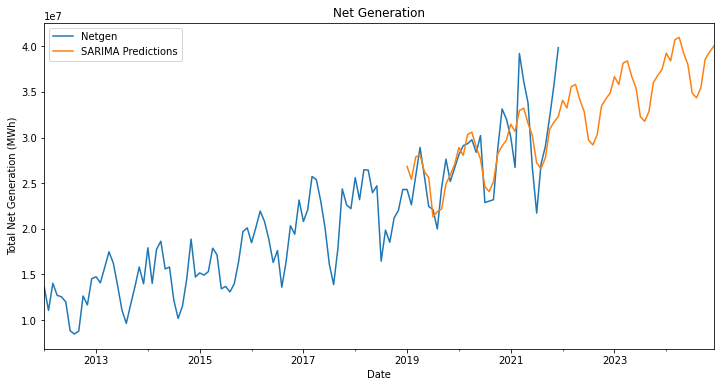

In [28]:
# fit sarima model using the best parameters
model = SARIMAX(train_sum['Netgen'], order=(0, 1, 0), seasonal_order=(2, 1, 1, 12))
results = model.fit()

# predict
start = '2019-01-31'
end = '2024-12-31'
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')

# plot whole length of data with prediction
ax = df_monthly_2012_2021_wt_ws_netgen_sum['Netgen'].plot(legend=True, figsize=(12, 6), title='Net Generation')
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel='Date', ylabel='Total Net Generation (MWh)')


# forecast mean net generation (total divided by number of plants)

In [30]:
# group by month and mean
df_monthly_2012_2021_wt_ws_netgen_mean = df_monthly_2012_2021_wt_ws_netgen.groupby(df_monthly_2012_2021_wt_ws_netgen.index)['Netgen'].mean()


# index to datetime
df_monthly_2012_2021_wt_ws_netgen_mean.index = pd.to_datetime(df_monthly_2012_2021_wt_ws_netgen_mean.index)

df_monthly_2012_2021_wt_ws_netgen_mean.head()

date
2012-01-01    19899.060250
2012-02-01    15947.639491
2012-03-01    20154.231269
2012-04-01    18207.783107
2012-05-01    17889.192963
Name: Netgen, dtype: float64

In [31]:
# split train and test
train_mean = df_monthly_2012_2021_wt_ws_netgen_mean[:'2018-12-01']
test_mean = df_monthly_2012_2021_wt_ws_netgen_mean['2019-01-01':]

In [32]:
# loop sarima order and seasonal order
order_list = []
seasonal_order_list = []
error_list = []

for i in order:
    for j in seasonal_order:
        model = SARIMAX(train_mean, order=i, seasonal_order=j)
        results = model.fit()
        start = '2019-01-31'
        end = '2021-12-31'
        predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')
        error = mean_squared_error(test_mean, predictions)
        root_error = np.sqrt(error)
        order_list.append(i)
        seasonal_order_list.append(j)
        error_list.append(root_error)

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\si

LinAlgError: LU decomposition error.

In [33]:
# dataframe to store the results
df_sarima_mean_results = pd.DataFrame({'order': order_list, 'seasonal_order': seasonal_order_list, 'error': error_list})

# print the top 5 results
df_sarima_mean_results.sort_values(by='error', ascending=True).head()

# export the results
#df_sarima_mean_results.to_csv(r"C:\Users\danie\Downloads\sprint\sarima_results.csv")


,order,seasonal_order,error
153,"(0, 1, 0)","(2, 0, 2, 12)",2371.770557
160,"(0, 1, 0)","(2, 1, 2, 12)",2384.595932
180,"(1, 1, 0)","(1, 1, 2, 12)",2421.730672
179,"(1, 1, 0)","(2, 1, 1, 12)",2422.842577
178,"(1, 1, 0)","(1, 1, 1, 12)",2422.854673


c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Mean Net Generation')]

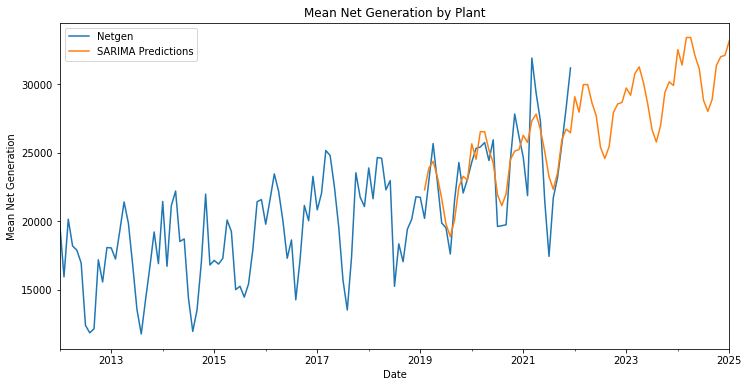

In [34]:
# fit sarima model
model = SARIMAX(train_mean, order=(0, 1, 0), seasonal_order=(2, 0, 2, 12))
results = model.fit()

# predict
start = '2019-01-31'
end = '2024-12-31'
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')

# plot whole length of data with prediction
ax = df_monthly_2012_2021_wt_ws_netgen_mean.plot(legend=True, figsize=(12, 6), title='Mean Net Generation by Plant')
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel='Date', ylabel='Mean Net Generation')

# operator level forecast

In [35]:
# filter out the name of the operator
df_monthly_op = df_monthly_2012_2021_wt_ws[df_monthly_2012_2021_wt_ws['Operator'].str.contains()]

,Plant Id,Operator Name,Reported\nPrime Mover,YEAR,Month,Quantity,Elec_Quantity,MMBtuPer_Unit,Tot_MMBtu,Elec_MMBtu,Netgen
date,,,,,,,,,,,
2012-01-01,56591,United Materials of Great Falls Inc,WT,2012,January,0.0,0.0,0.0,28011.0,28011.0,2943.615
2012-01-01,57171,Montana-Dakota Utilities Co,WT,2012,January,0.0,0.0,0.0,40692.0,40692.0,4276.156
2012-01-01,57174,Colorado Highlands Wind LLC,WT,2012,January,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01,57176,First State Marine Wind,WT,2012,January,0.0,0.0,0.0,5440.0,5440.0,571.678
2012-01-01,57177,Meadow Lake Wind Farm IV LLC,WT,2012,January,0.0,0.0,0.0,287583.0,287583.0,30221.000
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,56990,"Evergreen Wind, LLC",WT,2021,December,0.0,0.0,0.0,147307.0,147307.0,16656.118
2021-12-01,56989,"Evergreen Wind, LLC",WT,2021,December,0.0,0.0,0.0,115903.0,115903.0,13105.286
2021-12-01,56985,Smoky Hills Wind Project II LLC,WT,2021,December,0.0,0.0,0.0,389493.0,389493.0,44040.394


In [ ]:
# drop all column and na
df_monthly_op_netgen = df_monthly_op.drop(['YEAR', 'Month', 'Reported\nPrime Mover', 'Plant Id', 'Operator Name'
                                                              'Quantity', 'Elec_Quantity', 'MMBtuPer_Unit', 'Tot_MMBtu', 'Elec_MMBtu'], axis=1)
print(len(df_monthly_op_netgen))
df_monthly_op_netgen = df_monthly_op_netgen.dropna()
print(len(df_monthly_op_netgen))
df_monthly_op_netgen.head()

In [ ]:
# group by month and sum
df_monthly_op_netgen_sum = df_monthly_op_netgen.groupby(pd.Grouper(freq='M')).sum()

# index to datetime
df_monthly_op_netgen_sum.index = pd.to_datetime(df_monthly_op_netgen_sum.index)

In [ ]:
# get the min and max date
print(df_monthly_op_netgen_sum.index.min())
print(df_monthly_op_netgen_sum.index.max())

In [ ]:
# split train and test
train_sum = df_monthly_2012_2021_wt_ws_netgen_sum[:'2018-12-31']
test_sum = df_monthly_2012_2021_wt_ws_netgen_sum['2019-01-31':]

In [ ]:
# loop sarima order and seasonal order
order_list = []
seasonal_order_list = []
error_list = []

for i in order:
    for j in seasonal_order:
        model = SARIMAX(train_sum, order=i, seasonal_order=j)
        results = model.fit()
        start = '2019-01-31'
        end = '2021-12-31'
        predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')
        error = mean_squared_error(test_sum, predictions)
        root_error = np.sqrt(error)
        order_list.append(i)
        seasonal_order_list.append(j)
        error_list.append(root_error)

In [ ]:
# create a dataframe to store the results
df_sarima_op_sum_results = pd.DataFrame({'order': order_list, 'seasonal_order': seasonal_order_list, 'error': error_list})

# print the top 5 results
print(df_sarima_op_sum_results.sort_values(by='error', ascending=True).head())

# export the results
#df_sarima_sum_results.to_csv(r"C:\Users\danie\Downloads\sprint\sarima_results.csv")

In [ ]:
# fit sarima model
model = SARIMAX(train_mean, order=(0, 1, 0), seasonal_order=(2, 0, 2, 12))
results = model.fit()

# predict
start = '2019-01-31'
end = '2024-12-31'
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')

# plot whole length of data with prediction
ax = df_monthly_2012_2021_wt_ws_netgen_mean.plot(legend=True, figsize=(12, 6), title='Mean Net Generation by Plant')
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel='Date', ylabel='Mean Net Generation')